In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import esmlab
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy
import cartopy.crs as ccrs
import seawater as sw
from seawater.library import T90conv
from scipy import stats
import pop_tools 
import ncar_jobqueue
from dask.distributed import Client

Cannot write to data cache folder '/glade/p/cesmdata/cseg'. Will not be able to download remote data files. Use environment variable 'CESMDATAROOT' to specify another directory.


Note: this notebook uses annual means for all 5 IAFs.

These means were made using this notebook:
/glade/u/home/kristenk/besome/alk-calc_transient_response/make_annual_mean_tseries.ipynb

### get ALK control

In [2]:
case='cesm22cocco.G1850ECOIAF.T62_g17.003'

In [3]:
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.ALK.0001-0062.nc'
ds_1 = xr.open_dataset(file,decode_times=False,decode_coords=False)

In [4]:
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.ALK.0063-0124.nc'
ds_2 = xr.open_dataset(file,decode_times=False,decode_coords=False)

In [5]:
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.ALK.0125-0186.nc'
ds_3 = xr.open_dataset(file,decode_times=False,decode_coords=False)

In [6]:
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.ALK.0187-0248.nc'
ds_4 = xr.open_dataset(file,decode_times=False,decode_coords=False)

In [7]:
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.ALK.0249-0310.nc'
ds_5 = xr.open_dataset(file,decode_times=False,decode_coords=False)

In [8]:
ds_alk = xr.concat([ds_1, ds_2, ds_3, ds_4, ds_5], 'time')

### get ALK noGCB

In [9]:
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.ALK_ALT_CO2.0001-0062.nc'
ds_1 = xr.open_dataset(file,decode_times=False,decode_coords=False)

In [10]:
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.ALK_ALT_CO2.0063-0124.nc'
ds_2 = xr.open_dataset(file,decode_times=False,decode_coords=False)

In [11]:
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.ALK_ALT_CO2.0125-0186.nc'
ds_3 = xr.open_dataset(file,decode_times=False,decode_coords=False)

In [12]:
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.ALK_ALT_CO2.0187-0248.nc'
ds_4 = xr.open_dataset(file,decode_times=False,decode_coords=False)

In [13]:
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.ALK_ALT_CO2.0249-0310.nc'
ds_5 = xr.open_dataset(file,decode_times=False,decode_coords=False)

In [14]:
ds_alk_noGCB = xr.concat([ds_1, ds_2, ds_3, ds_4, ds_5], 'time')

### get ALK with 2x GCB

In [15]:
case='cesm22cocco.G1850ECOIAF.T62_g17.004'

In [16]:
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.ALK_ALT_CO2.0001-0062.nc'
ds_1 = xr.open_dataset(file,decode_times=False,decode_coords=False)

In [17]:
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.ALK_ALT_CO2.0063-0124.nc'
ds_2 = xr.open_dataset(file,decode_times=False,decode_coords=False)

In [18]:
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.ALK_ALT_CO2.0125-0186.nc'
ds_3 = xr.open_dataset(file,decode_times=False,decode_coords=False)

In [19]:
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.ALK_ALT_CO2.0187-0248.nc'
ds_4 = xr.open_dataset(file,decode_times=False,decode_coords=False)

In [20]:
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.ALK_ALT_CO2.0249-0310.nc'
ds_5 = xr.open_dataset(file,decode_times=False,decode_coords=False)

In [21]:
ds_alk_2xGCB = xr.concat([ds_1, ds_2, ds_3, ds_4, ds_5], 'time')

### Now we have everything we need

In [22]:
file = '/glade/work/kristenk/WOA_data/regrid_POP/WOA2013_POPgrid.nc' 
ds_woa = xr.load_dataset(file, decode_times=False, decode_coords=False)
ds_woa['z_t'] = ds_alk.z_t

In [23]:
lons=ds_woa.TLONG
lats=ds_woa.TLAT
area=ds_woa.TAREA
area_m=ds_woa.TAREA * 1e-4
depths_m=ds_woa.z_t * 0.01
dz=ds_woa.dz
dz_m=ds_woa.dz * 0.01

### vertically integrate ALK control

In [24]:
%%time
ALKzint_ts = esmlab.weighted_sum(ds_alk.ALK, weights=dz_m, dim=['z_t']).compute()
#dims: nlon,nlat,time
#ALKzint_ts = ALKzint_ts * 0.001 #mol

CPU times: user 34.1 s, sys: 2min 3s, total: 2min 37s
Wall time: 5min 1s


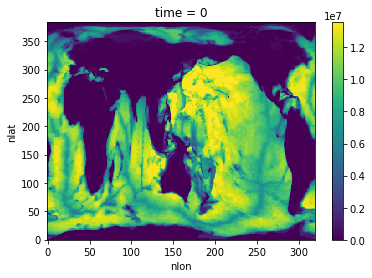

In [67]:
ALKzint_ts.isel(time=0).plot()

### Total up ALK noGCB

In [25]:
%%time
ALKzint_noGCBts = esmlab.weighted_sum(ds_alk_noGCB.ALK_ALT_CO2, weights=dz_m, dim=['z_t']).compute()
#dims: nlon,nlat,time

CPU times: user 38 s, sys: 2min 39s, total: 3min 17s
Wall time: 9min 52s


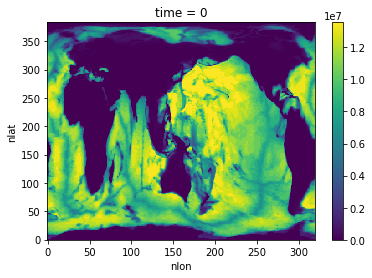

In [26]:
ALKzint_noGCBts.isel(time=0).plot()

### Total up ALK 2xGCB

In [33]:
ds_alk_2xGCB.time

<xarray.DataArray 'time' (time: 310)>
array([    0,   365,   730, ..., 21535, 21900, 22265])
Coordinates:
  * time     (time) int64 0 365 730 1095 1460 ... 20805 21170 21535 21900 22265
Attributes:
    calendar:  noleap

In [28]:
%%time
ALKzint_2xGCBts = esmlab.weighted_sum(ds_alk_2xGCB.ALK_ALT_CO2, weights=dz_m, dim=['z_t']).compute()
#dims: nlon,nlat,time

CPU times: user 37.1 s, sys: 2min 22s, total: 3min
Wall time: 8min 50s


In [71]:
years=np.arange(1,311,1)

### make diffs from control

In [29]:
diff_zintAlk_noGCB = (ALKzint_noGCBts - ALKzint_ts) /1000. #converting from mmol/m2 to mol/2

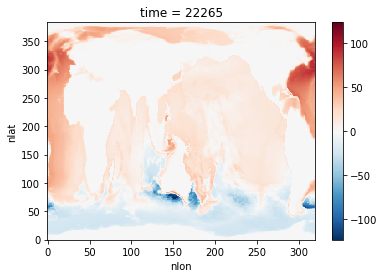

In [34]:
diff_zintAlk_noGCB.isel(time=309).plot()

In [35]:
diff_zintAlk_2xGCB = (ALKzint_2xGCBts - ALKzint_ts) / 1000. 

#### Get basin mask

In [36]:
grid_name = 'POP_gx1v7'

region_mask='Pacific-Indian-Atlantic'
mask3d_basins = pop_tools.region_mask_3d(grid_name, mask_name=region_mask)

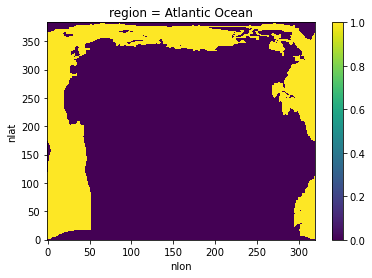

In [37]:
mask3d_basins.isel(region=1).plot()

### Mask out North Atlantic and make timeseries, using this latitude range:
#### 30°N to 70°N

In [38]:
NAtl_noGCB_diff = diff_zintAlk_noGCB.where(lats>30.).where(lats<70.)
NAtl_noGCB_diff = NAtl_noGCB_diff.where(mask3d_basins.isel(region=1)==1)

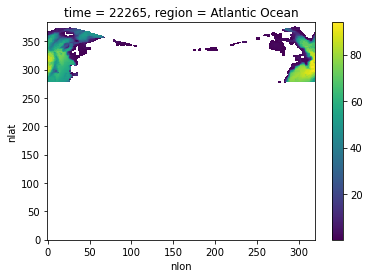

In [41]:
NAtl_noGCB_diff.isel(time=309).plot()

In [42]:
NAtl_2xGCB_diff = diff_zintAlk_2xGCB.where(lats>30.).where(lats<70.)
NAtl_2xGCB_diff = NAtl_2xGCB_diff.where(mask3d_basins.isel(region=1)==1)

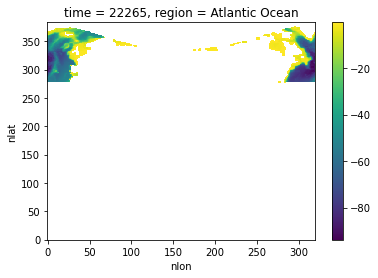

In [43]:
NAtl_2xGCB_diff.isel(time=309).plot()

In [44]:
NAtl_noGCB_diff_ts = esmlab.weighted_mean(NAtl_noGCB_diff, weights=area_m, dim=['nlon','nlat']).compute()

In [46]:
NAtl_2xGCB_diff_ts = esmlab.weighted_mean(NAtl_2xGCB_diff, weights=area_m, dim=['nlon','nlat']).compute()

In [48]:
years=np.arange(1,311,1)

#### Plot a timeseries of zint ALK diffs in the North Atlantic

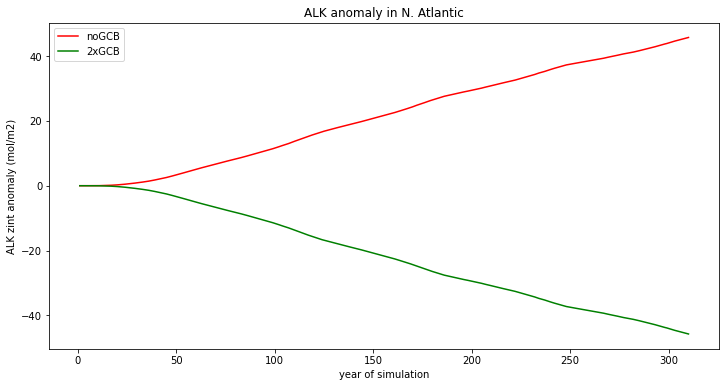

In [51]:
fig = plt.figure(figsize=(12,6))

ax = fig.add_subplot(1,1,1)
ax.set_title('ALK anomaly in N. Atlantic')

ax.plot(years,NAtl_noGCB_diff_ts,color='red', label='noGCB')
ax.plot(years,NAtl_2xGCB_diff_ts,color='green', label='2xGCB')

ax.set(ylabel='ALK zint anomaly (mol/m2)',xlabel='year of simulation')
ax.legend()